# Physics-Informed Neural Network (PINN) for 1D Heat Equation
This notebook demonstrates solving the 1D heat equation using PINNs.


In [ ]:
!pip install deepxde matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.7 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

def initial_condition(x):
    return np.sin(np.pi * x[:, 0:1])

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

ic = dde.IC(geomtime, initial_condition, lambda _, on_initial: on_initial)
bc1 = dde.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))
bc2 = dde.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 1))

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


The PDE (1D Heat Equation)

The equation is:

𝑢
𝑡 =
𝛼
𝑢
𝑥
𝑥
,
𝑥
∈
(
0
,
1
)
,
𝑡
∈
(
0
,
1
)

In [ ]:
# Thermal diffusivity
alpha = 0.01

def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)   # ∂u/∂t
    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # ∂²u/∂x²
    return du_t - alpha * du_xx

Boundary & Initial Conditions

We’ll assume:

Initial condition: u(x,0) = sin(pi * x)

Boundary condition: u(0,t) = u(1,t) = 0

In [ ]:
def initial_condition(x):
    return np.sin(np.pi * x[:, 0:1])

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

ic = dde.IC(geomtime, initial_condition, lambda _, on_initial: on_initial)
bc1 = dde.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))
bc2 = dde.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 1))

PINN Model

In [ ]:
# Define neural network
layer_size = [2] + [50] * 3 + [1]   # Input (x,t), 3 hidden layers, 1 output (u)
activation = "tanh"
initializer = "Glorot normal"

net = dde.maps.FNN(layer_size, activation, initializer)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [ic, bc1, bc2],
    num_domain=2000,
    num_boundary=200,
    num_initial=200,
)

model = dde.Model(data, net)

Train the Model

In [ ]:
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.102506 s

'compile' took 0.569278 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.18e-02, 5.65e-01, 1.90e-02, 4.29e-02]    [5.18e-02, 5.65e-01, 1.90e-02, 4.29e-02]    []  
1000      [2.68e-04, 2.18e-04, 4.34e-05, 1.85e-05]    [2.68e-04, 2.18e-04, 4.34e-05, 1.85e-05]    []  
2000      [1.21e-04, 9.66e-05, 1.79e-05, 1.27e-05]    [1.21e-04, 9.66e-05, 1.79e-05, 1.27e-05]    []  
3000      [8.17e-05, 6.15e-05, 9.87e-06, 1.24e-05]    [8.17e-05, 6.15e-05, 9.87e-06, 1.24e-05]    []  
4000      [6.01e-05, 4.60e-05, 6.34e-06, 1.21e-05]    [6.01e-05, 4.60e-05, 6.34e-06, 1.21e-05]    []  
5000      [4.27e-05, 3.36e-05, 3.68e-06, 1.12e-05]    [4.27e-05, 3.36e-05, 3.68e-06, 1.12e-05]    []  

Best model at step 5000:
  train loss: 9.12e-05
  test loss: 9.12e-05
  test metric: []

'train' took 121.507455 s



Visualize Results

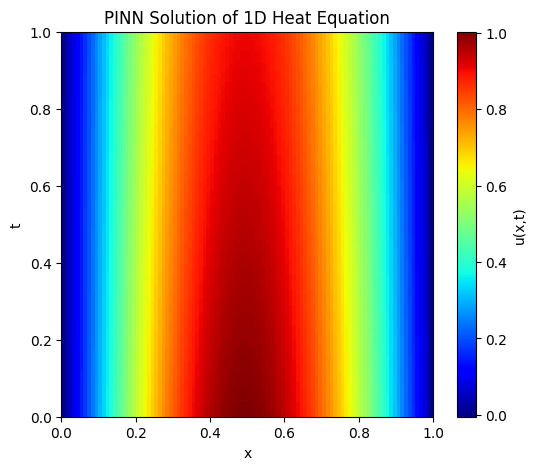

In [ ]:
X = np.linspace(0, 1, 100)[:, None]
T = np.linspace(0, 1, 100)[:, None]
X, T = np.meshgrid(X, T)
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

u_pred = model.predict(XT)
U = u_pred.reshape(100, 100)

plt.figure(figsize=(6,5))
plt.imshow(U, extent=[0,1,0,1], origin="lower", aspect="auto", cmap="jet")
plt.colorbar(label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Solution of 1D Heat Equation")
plt.show()